In [1]:
from __future__ import print_function
%matplotlib inline

In [2]:
import os, h5py
from skimage.transform import resize
from skimage.io import imsave, imshow
from skimage.exposure import equalize_adapthist

import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
FolderPath = "../../dataset/ultrasound_nerve_segmentation/"

K.set_image_dim_ordering('tf')
#K.set_floatx('float16')

#original size : 420x580
img_rows=96
img_cols=96

f_size = 1
learning_rate = 1e-2
activation = 'elu'

smooth = 1.


In [4]:
def load_train_data():
    with h5py.File(FolderPath + 'X_Train.h5', 'r') as hf:
        imgs_train = hf['X_Train'][:]
    with h5py.File(FolderPath + 'Y_Train.h5', 'r') as hf:
        imgs_mask_train = hf['Y_Train'][:]
    
    return imgs_train, imgs_mask_train


# In[6]:

def load_test_data():
    with h5py.File(FolderPath + 'X_Test.h5', 'r') as hf:
        imgs_test = hf['X_Test'][:]
    with h5py.File(FolderPath + 'Y_Test.h5', 'r') as hf:
        imgs_mask_test = hf['Y_Test'][:]
        
    return imgs_test, imgs_mask_test

In [5]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [6]:
def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Convolution2D(3, 1, 1, activation=activation, border_mode='same')(inputs)

    conv1 = Convolution2D(32, 3, 3, activation=activation, border_mode='same')(conv1)
    conv1 = Convolution2D(32, 3, 3, activation=activation, border_mode='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation=activation, border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation=activation, border_mode='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation=activation, border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation=activation, border_mode='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Convolution2D(256, 3, 3, activation=activation, border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation=activation, border_mode='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Convolution2D(512, 3, 3, activation=activation, border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation=activation, border_mode='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)
    conv6 = Convolution2D(256, 3, 3, activation=activation, border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation=activation, border_mode='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
    conv7 = Convolution2D(128, 3, 3, activation=activation, border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation=activation, border_mode='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=3)
    conv8 = Convolution2D(64, 3, 3, activation=activation, border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation=activation, border_mode='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
    conv9 = Convolution2D(32, 3, 3, activation=activation, border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation=activation, border_mode='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    
    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_loss, metrics=[dice_coef])
    model.summary()
    
    return model

In [7]:
def exposure_image(X):
    Xf = np.array(X)
    for i in xrange(X.shape[0]):
        Xf[i] = equalize_adapthist(X[i])
    return Xf

def preprocess(X,y):
    X = (X / 255.).astype(np.float32)
    y = (y / 255.).astype(np.float32)

    X = exposure_image(X)
    
    return X,y

In [8]:
def resize_image(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.float32)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

In [9]:
model = get_unet()
model_checkpoint = ModelCheckpoint('model_UNET.hdf5', monitor='loss', save_best_only=True)
model_earlystopping = EarlyStopping(monitor='loss')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 96, 96, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 96, 96, 3)     6           input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 96, 96, 32)    896         convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 96, 96, 32)    9248        convolution2d_2[0][0]            
___________________________________________________________________________________________

In [10]:
imgs_train, imgs_mask_train = load_train_data()

In [11]:
imgs_train, imgs_mask_train = preprocess(imgs_train, imgs_mask_train)

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [12]:
imgs_train = resize_image(imgs_train)
imgs_mask_train = resize_image(imgs_mask_train)

In [13]:
imgs_train.shape, imgs_mask_train.shape

((4508, 96, 96, 1), (4508, 96, 96, 1))

In [28]:
model.fit(imgs_train, imgs_mask_train, batch_size=64, nb_epoch=20, verbose=1, shuffle=True,
          validation_split=0.2,
          callbacks=[model_checkpoint, model_earlystopping])

Train on 3606 samples, validate on 902 samples
Epoch 1/20
3606/3606 [==============================] - 19s - loss: -0.6020 - dice_coef: 0.6020 - val_loss: -0.1533 - val_dice_coef: 0.1533

In [29]:
imgs_test, imgs_id_test = load_test_data()

In [30]:
imgs_test, imgs_id_test = preprocess(imgs_test, imgs_id_test)

In [31]:
imgs_test = resize_image(imgs_test)
imgs_id_test = resize_image(imgs_id_test)

In [32]:
model.load_weights('model_UNET.hdf5')

In [33]:
loss, accu = model.evaluate(imgs_test, imgs_id_test, verbose=1)
print("loss:{}%, accuracy:{}%".format(loss*100, accu*100))

1120/1127 [============================>.] - ETA: 0s

In [34]:
imgs_pred_test = model.predict(imgs_test, verbose=1)

1120/1127 [============================>.] - ETA: 0s

In [35]:
pred_dir = 'preds'
test_dir = 'tests'
if not os.path.exists(pred_dir):
    os.mkdir(pred_dir)
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

In [36]:
# for image_id, image in enumerate(imgs_pred_test):
#     image = (image[:,:,0] * 255.).astype(np.uint8)
#     imsave(os.path.join(pred_dir, str(image_id) + '_pred.png'), image)

In [37]:
imgs_test.shape

(1127, 96, 96, 1)

In [38]:
def plot_compare(idx):
    plt.figure(dpi=40)
    plt.subplot(131)
    imshow(imgs_id_test[idx,:,:,0],cmap='gray')
    plt.subplot(132)
    imshow(imgs_test[idx,:,:,0],cmap='gray')
    imshow(imgs_pred_test[idx,:,:,0],cmap='jet', alpha=0.5)
    plt.subplot(133)
    imshow(imgs_id_test[idx,:,:,0] - imgs_pred_test[idx,:,:,0], cmap='gray')
    plt.savefig(os.path.join(test_dir, 'test' + str(idx) + '.png'))

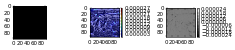

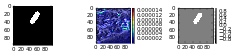

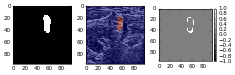

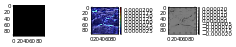

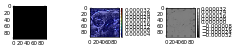

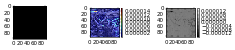

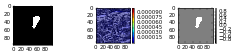

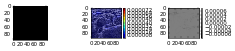

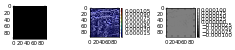

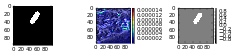

In [42]:
ran_idx = np.random.randint(0, imgs_test.shape[0],10)
for i,idx in enumerate(ran_idx):
    plot_compare(idx)